In [ ]:
# Copyright 2019 Google LLC
# Copyright 2025 Anonymized Authors

# Licensed under the Apache License, Version 2.0 (the "License"); 
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at
# https://www.apache.org/licenses/LICENSE-2.0
"""
This notebook benchmarks GENE and regularized evolution on NAS-Bench-101.
It uses a population size of 50 and mutation rate of 0.72 for RE. 
flat one hot encoding for the operations and a binary adjacency matrix encoding.

The resulting Spec is a Mixed Spec object.

Requirements: 

-This notebook requires that  tensorflow and numpy be installed within the 
Python environment you are running this script in. 

"""
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from typing import Callable, Any,List
import copy


import sys; sys.path.append('..')
from utils.nas_utils import load_nasbench,  NASBenchConstants, NASBench, ModelSpec
from utils.plotting import plot_all
from IPython.display import clear_output


nasb = load_nasbench()




No GPU.
Loading dataset from file... This may take a few minutes...
Loaded dataset in 482.59514260292053 seconds


In [2]:
from typing import Callable, Any,List
import copy

In [7]:
def random_spec(nasbench: NASBench):
    """Returns a random valid spec."""
    while True:
        matrix = np.random.choice(NASBenchConstants.ALLOWED_EDGES,
                                  size=(NASBenchConstants.NUM_VERTICES, NASBenchConstants.NUM_VERTICES))
        matrix = np.triu(matrix, 1)
        ops = np.random.choice(NASBenchConstants.ALLOWED_OPS, size=NASBenchConstants.NUM_VERTICES).tolist()
        ops[0] = NASBenchConstants.INPUT
        ops[-1] = NASBenchConstants.OUTPUT
        spec = SpecOneHot(matrix=matrix, ops=ops)
        if nasbench.is_valid(spec):
            return spec


class SpecOneHot(ModelSpec):
    """Spec extension to support categorical one-hot for operations and adjacency matrix."""

    flat_matrix = ((NASBenchConstants.NUM_VERTICES-1+1)*(NASBenchConstants.NUM_VERTICES-1)//2) * 2
    input_size = ((NASBenchConstants.NUM_VERTICES-1+1)*(NASBenchConstants.NUM_VERTICES-1)//2)*2 + len(NASBenchConstants.ALLOWED_OPS)*(NASBenchConstants.NUM_VERTICES - 2)
  
    name_lu = {op: np.eye(3)[i] for i, op in enumerate(NASBenchConstants.ALLOWED_OPS)}
    onehot_lu = list(name_lu.values())

    def __init__(self, matrix, ops):
        super().__init__(matrix=matrix, ops=ops)
        # self.flat = self.to_flat() # only when using instead of when initializing

    def to_flat(self):
        ops = self.original_ops[1:-1] # omit first and last one 
        mat = self.original_matrix
        ops_onehot = np.concatenate([SpecOneHot.name_lu[s] for s in ops])
        flat = self.encode(mat, ops_onehot)
        return flat.astype(int)

    @staticmethod
    def encode(matrix,ops_onehot):
        # TRIU only uses upper triangle matrix indices including diagonal
        onehot_matrix = np.eye(2)[matrix[NASBenchConstants.TRIU]].flatten()
        flattened =  np.concatenate((onehot_matrix,ops_onehot))
        return flattened
    
    @staticmethod
    def decode(flat):
        matrix = np.zeros((NASBenchConstants.NUM_VERTICES, NASBenchConstants.NUM_VERTICES), dtype=flat.dtype)
        onehot_matrix = flat[:SpecOneHot.flat_matrix].reshape((-1,2))
        entries = np.argmax(onehot_matrix, 1)
        matrix[NASBenchConstants.TRIU] = entries
        assert np.all(np.triu(matrix) == matrix)

        ops_onehot = flat[SpecOneHot.flat_matrix:].reshape((NASBenchConstants.NUM_VERTICES - 2, len(NASBenchConstants.ALLOWED_OPS)))
        assert np.sum(ops_onehot) == NASBenchConstants.NUM_VERTICES - 2

        indices = np.argmax(ops_onehot, 1)
        return matrix, indices

    @staticmethod
    def test_decode_encode():
        rando = np.random.randint(2, size=NASBenchConstants.NUM_VERTICES*NASBenchConstants.NUM_VERTICES)
        matrix = rando.reshape((NASBenchConstants.NUM_VERTICES, NASBenchConstants.NUM_VERTICES))
        matrix = np.triu(matrix, 1)
        ops_ind = np.random.choice(NASBenchConstants.OPS_IND, size=NASBenchConstants.NUM_VERTICES-2)
        ops_onehot = np.concatenate([SpecOneHot.onehot_lu[i] for i in ops_ind])
        flat = SpecOneHot.encode(matrix,ops_onehot)
        m,o = SpecOneHot.decode(flat)
        assert np.array_equal(matrix,m) 
        assert np.array_equal(ops_ind,o) 

    @staticmethod
    def spec_from_flat(flat):
        matrix,indices = SpecOneHot.decode(flat)
        ops = np.asarray(NASBenchConstants.ALLOWED_OPS)[indices]
        cops = np.concatenate(([NASBenchConstants.INPUT], ops, [NASBenchConstants.OUTPUT])).tolist()      
        spec = SpecOneHot(matrix=matrix, ops=cops)
        return spec
    
def init_pop(nasbench, max_time_budget, p_size=50):


    """Initializes a population of given psize"""

    times, best_valids, best_tests = [0.0], [0.0], [0.0]
    population = []  # (validation, spec) tuples

    # For the first population_size individuals, seed the population with
    # randomly generated cells.
    for _ in range(p_size):
        spec = random_spec(nasbench)
        data = nasbench.query(spec)
        time_spent, _ = nasbench.get_budget_counters()
        times.append(time_spent)
        population.append((data["validation_accuracy"], spec))

        if data["validation_accuracy"] > best_valids[-1]:
            best_valids.append(data["validation_accuracy"])
            best_tests.append(data["test_accuracy"])
        else:
            best_valids.append(best_valids[-1])
            best_tests.append(best_tests[-1])

        if time_spent > max_time_budget:
            break
    return population, times, best_valids, best_tests


In [ ]:
def greedy_selection(parents):
    """Selects greedy n parent pairs"""
    p_size = len(parents)
    population = np.asarray([p[0] for p in parents])

    summed_population = []
    for p1 in range(p_size):
        for p2 in range(p_size):
            if p1 < p2: # only upper triangle
                sum = population[p1] + population[p2]
            else:
                sum = 0
            summed_population.append(sum)

    samples = np.argsort(summed_population)[-p_size:]
    row_indices, col_indices = np.meshgrid(np.arange(p_size),np.arange(p_size))
    mapping = np.reshape(np.stack([col_indices,row_indices],axis=-1), [-1,2])
    pairings = mapping[samples]

    paired_parents = []
    for i in range(len(pairings)):
        p1 = parents[pairings[i,0]]
        p2 = parents[pairings[i,1]]
        paired_parents.append((p1,p2))

    return paired_parents


# crossover with no fixed crossover point
def crossover(nasb, parents):
    """Performs vertical crossover on parent pairs, ensuring valid offspring."""
    
    def cross(p1, p2):
        if p1.original_matrix.shape != p2.original_matrix.shape:
            print("Shape mismatch")
            return p1

        for _ in range(5):
            i = random.randint(1, NASBenchConstants.NUM_VERTICES - 1)
            m = np.copy(p1.original_matrix)
            m[:i, :] = p2.original_matrix[:i, :]
            o = p1.original_ops[:i] + p2.original_ops[i:]
            new_spec = SpecOneHot(m, o)
            if nasb.is_valid(new_spec):
                return new_spec
        return p1

    return [cross(p[0][1], p[1][1]) for p in parents]



def guided_mutation(nasb, population, mode=0):
    psize = len(population)
    
    # Convert the inputs to NumPy arrays (assuming population is a list of objects with 'flat' attribute)
    inputs = [x.to_flat() for x in population]
    
    # Convert list of lists/arrays into a 2D NumPy array
    mutation_inputs = np.array(inputs)
    
    # Sum across the first axis (population size), axis=0 corresponds to summing across rows (for each feature)
    summed = np.sum(mutation_inputs, axis=0)

    # Define the probabilities for mutation
    probs_mat_1 = summed[:SpecOneHot.flat_matrix] / psize  # Mass of ones for flat matrix
    probs_mat_1 /= np.sum(probs_mat_1)  # Normalize so the sum of probabilities is 1
    probs_mat_0 = 1 - probs_mat_1  # Mass of zeros for flat matrix
    probs_mat_0 /= np.sum(probs_mat_0)  # Normalize so the sum of probabilities is 1

    probs_ops_1 = summed[SpecOneHot.flat_matrix:] / psize  # Mass of ones for operations
    probs_ops_1 /= np.sum(probs_ops_1)  # Normalize so the sum of probabilities is 1
    probs_ops_0 = 1 - probs_ops_1
    probs_ops_0 /= np.sum(probs_ops_0)  # Normalize so the sum of probabilities is 1

    # Select which probabilities to use based on mode
    if mode == 1:
        probs_ops = probs_ops_1
    elif mode == 0:
        probs_ops = probs_ops_0
    else:
        print("mode can either be 0 or 1")

    children = []
    for i in range(psize):
        while True:
            child_spec = mutation_inputs[i, :].astype(int)

            # Select indices based on the probabilities using np.random.choice (similar to torch.multinomial)
            mat_index_1 = np.random.choice(len(probs_mat_0), 1, p=probs_mat_0)[0]
            mat_index_0 = np.random.choice(len(probs_mat_1), 1, p=probs_mat_1)[0]
            ops_index = np.random.choice(len(probs_ops), 1, p=probs_ops)[0] + SpecOneHot.flat_matrix

            # Modify the child_spec array based on the selected indices
            base = (ops_index - (ops_index % 3))  # Ensure base is aligned to 3 operations
            remove = [base, base + 1, base + 2]
            child_spec[remove] = 0
            child_spec[ops_index] = 1

            # set 0 to 1
            base2 = (mat_index_1 - (mat_index_1%2))
            remove2 = [base2, base2+1] 
            child_spec[remove2] = 0
            child_spec[base2] = 1


            # set 1 to 0
            base3 = (mat_index_0 - (mat_index_0%2))
            remove3 = [base3, base3+1] 
            child_spec[remove3] = 0
            child_spec[base3+1] = 1

            # Assuming SpecOneHot.spec_from_flat is a function that returns a spec from a flat representation
            spec = SpecOneHot.spec_from_flat(child_spec)
            
            if nasb.is_valid(spec):
                children.append(spec)
                break

    return children



def guided_mutation_mode(nasb, population, mode="00"):
    psize = len(population)
    
    # Convert the inputs to NumPy arrays (assuming population is a list of objects with 'flat' attribute)
    inputs = [x.to_flat() for x in population]
    
    # Convert list of lists/arrays into a 2D NumPy array
    mutation_inputs = np.array(inputs)
    
    # Sum across the first axis (population size), axis=0 corresponds to summing across rows (for each feature)
    summed = np.sum(mutation_inputs, axis=0)

    # Define the probabilities for mutation
    probs_mat_1 = summed[:SpecOneHot.flat_matrix] / psize  # Mass of ones for flat matrix
    probs_mat_1 /= np.sum(probs_mat_1)  # Normalize so the sum of probabilities is 1
    probs_mat_0 = 1 - probs_mat_1  # Mass of zeros for flat matrix
    probs_mat_0 /= np.sum(probs_mat_0)  # Normalize so the sum of probabilities is 1

    probs_ops_1 = summed[SpecOneHot.flat_matrix:] / psize  # Mass of ones for operations
    probs_ops_1 /= np.sum(probs_ops_1)  # Normalize so the sum of probabilities is 1
    probs_ops_0 = 1 - probs_ops_1
    probs_ops_0 /= np.sum(probs_ops_0)  # Normalize so the sum of probabilities is 1

    # Select which probabilities to use based on mode
    if mode=="00":
        probs_mat = probs_mat_0
        probs_ops = probs_ops_0
    elif mode=="01":
        probs_mat = probs_mat_0
        probs_ops = probs_ops_1
    elif mode=="10":
        probs_mat = probs_mat_1
        probs_ops = probs_ops_0
    elif mode=="11":
        probs_mat = probs_mat_1
        probs_ops = probs_ops_1
    else:
        print("mode can either be 0 or 1")


    children = []
    for i in range(psize):
        while True:
            child_spec = mutation_inputs[i, :].astype(int)

            # Select indices based on the probabilities using np.random.choice (similar to torch.multinomial)
            mat_index = np.random.choice(len(probs_mat), 1, p=probs_mat)[0]
            ops_index = np.random.choice(len(probs_ops), 1, p=probs_ops)[0] + SpecOneHot.flat_matrix

            # Modify the child_spec array based on the selected indices
            base = (ops_index - (ops_index % 3))  # Ensure base is aligned to 3 operations
            remove = [base, base + 1, base + 2]
            child_spec[remove] = 0
            child_spec[ops_index] = 1

            base2 = (mat_index - (mat_index%2))
            remove2 = [base2, base2+1] 

            child_spec[remove2] = 0
            child_spec[mat_index] = 1

            # Assuming SpecOneHot.spec_from_flat is a function that returns a spec from a flat representation
            spec = SpecOneHot.spec_from_flat(child_spec)
            
            if nasb.is_valid(spec):
                children.append(spec)
                break

    return children



def run_xevolution(
    nasbench: NASBench,
    selection_algorithm: Callable[[List], Any],
    crossover_algorithm: Callable[[NASBench, List], Any],
    mutation_algorithm: Callable[[NASBench, List], Any],
    max_time_budget=5e6,
    p_size=50,    
):
    """Run a single roll-out of evolution to a fixed time budget."""
    population, times, best_valids, best_tests = init_pop(nasbench, max_time_budget, p_size)
    while True:
        # generational approach: children replace old population
        selected_candidates = selection_algorithm(population)  
        crossed_parents = crossover_algorithm(nasbench, selected_candidates)
        children = mutation_algorithm(nasbench, crossed_parents)
        population = []
        for child in children: 
            data = nasbench.query(child)
            time_spent, _ = nasbench.get_budget_counters()
            times.append(time_spent)
            population.append((data["validation_accuracy"], child))
            if data["validation_accuracy"] > best_valids[-1]:
                best_valids.append(data["validation_accuracy"])
                best_tests.append(data["test_accuracy"])
            else:
                best_valids.append(best_valids[-1])
                best_tests.append(best_tests[-1])

        if time_spent> max_time_budget:
            break

    return times, best_valids, best_tests


def random_combination(iterable, sample_size):
    """Random selection from itertools.combinations(iterable, r)."""
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), sample_size))
    return tuple(pool[i] for i in indices)

def mutate_spec(old_spec, nasbench: NASBench, mutation_rate=1.0):
    """Computes a valid mutated spec from the old_spec."""
    while True:
        new_matrix = copy.deepcopy(old_spec.original_matrix)
        new_ops = copy.deepcopy(old_spec.original_ops)

        # In expectation, V edges flipped (note that most end up being pruned).
        edge_mutation_prob = mutation_rate / NASBenchConstants.NUM_VERTICES
        for src in range(0, NASBenchConstants.NUM_VERTICES - 1):
            for dst in range(src + 1, NASBenchConstants.NUM_VERTICES):
                if random.random() < edge_mutation_prob:
                    new_matrix[src, dst] = 1 - new_matrix[src, dst]

        # In expectation, one op is resampled.
        op_mutation_prob = mutation_rate / NASBenchConstants.OP_SPOTS
        for ind in range(1, NASBenchConstants.NUM_VERTICES - 1):
            if random.random() < op_mutation_prob:
                available = [
                    o for o in nasbench.config["available_ops"]
                    if o != new_ops[ind]
                ]
                new_ops[ind] = random.choice(available)

        new_spec = SpecOneHot(new_matrix, new_ops)
        if nasbench.is_valid(new_spec):
            return new_spec

def run_revolution_search(
    nasbench: NASBench,
    max_time_budget=5e6,
    population_size=50,
    tournament_size=10,
    mutation_rate=0.5
):
    """Run a single roll-out of regularized evolution to a fixed time budget."""

    times, best_valids, best_tests = [0.0], [0.0], [0.0]
    population = []  # (validation, spec) tuples

    # For the first population_size individuals, seed the population with
    # randomly generated cells.
    for _ in range(population_size):
        spec = random_spec(nasbench)
        data = nasbench.query(spec)
        time_spent, _ = nasbench.get_budget_counters()
        times.append(time_spent)
        population.append((data["validation_accuracy"], spec))

        if data["validation_accuracy"] > best_valids[-1]:
            best_valids.append(data["validation_accuracy"])
            best_tests.append(data["test_accuracy"])
        else:
            best_valids.append(best_valids[-1])
            best_tests.append(best_tests[-1])

        if time_spent > max_time_budget:
            break
    # After the population is seeded, proceed with evolving the population.
    while True:
        sample = random_combination(population, tournament_size)
        best_spec = sorted(sample, key=lambda i: i[0])[-1][1]
        new_spec = mutate_spec(best_spec, nasbench, mutation_rate)

        data = nasbench.query(new_spec)
        time_spent, _ = nasbench.get_budget_counters()
        times.append(time_spent)

        # In regularized evolution, we kill the oldest individual.
        population.append((data["validation_accuracy"], new_spec))
        population.pop(0)

        if data["validation_accuracy"] > best_valids[-1]:
            best_valids.append(data["validation_accuracy"])
            best_tests.append(data["test_accuracy"])
        else:
            best_valids.append(best_valids[-1])
            best_tests.append(best_tests[-1])

        if time_spent > max_time_budget:
            break

    return times, best_valids, best_tests

In [ ]:
# comparing against greedy evolution and regularized evolution
gm0 = lambda nasb, crossed_parents: guided_mutation(nasb, crossed_parents, 1)


exp1 = {
    "data": 
    {
        "gm0" : [[],"Dark Orange"],
        "regularized evolution" : [[],"Very Dark Gray"],

    },
    "config": 
    {
        "budget" : int(5e6),
        "limits" : (0.9365, 0.9435),
        "n" : 100,
        "print_every" : 2,
        "confidence_intervall" : True,
        "pvalue" : 0.05,
        "significant_areas": False,
        "dataset" : "test",
   }
}

budget = exp1["config"]["budget"]
for run in range(exp1["config"]["n"]):
    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, gm0, budget, 50)
    exp1["data"]["gm0"][0].append((times, best_valid, best_test))

    # nasb.reset_budget_counters()
    # times, best_valid, best_test = run_xevolution(nasb, budget, greedy_selection, [], [0.],[0.],[0.], 32, gm0, cr)
    # exp1["data"]["guided mutation ops 0"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_revolution_search(nasb, budget, 50,10,0.72)
    exp1["data"]["regularized evolution"][0].append((times, best_valid, best_test))


    if (run % exp1["config"]["print_every"] == 0):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        plot_all(exp1, ax)
        plt.show()
        print('Running repeat %d' % (run + 1))

clear_output(wait=True)
fig, ax = plt.subplots()
plot_all(exp1, ax)
plt.show()

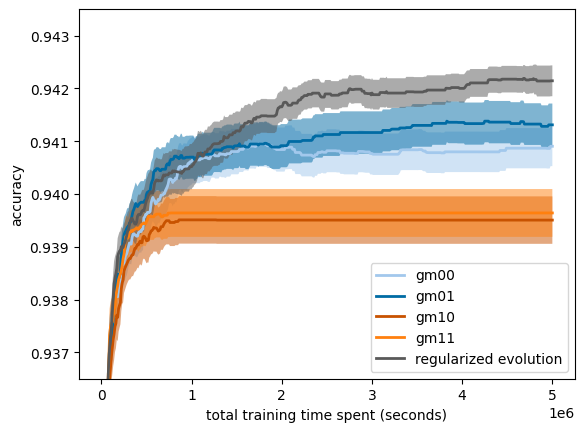

Running repeat 97


KeyboardInterrupt: 

In [28]:
# comparing against greedy evolution and regularized evolution
gm00 = lambda nasb, crossed_parents: guided_mutation_mode(nasb, crossed_parents, "00")
gm01 = lambda nasb, crossed_parents: guided_mutation_mode(nasb, crossed_parents, "01")
gm10 = lambda nasb, crossed_parents: guided_mutation_mode(nasb, crossed_parents, "10")
gm11 = lambda nasb, crossed_parents: guided_mutation_mode(nasb, crossed_parents, "11")


exp1 = {
    "data": 
    {
        "gm00" : [[],"Light Blue"],
        "gm01" : [[],"Dark Blue"],
        "gm10" : [[],"Red Orange"],
        "gm11" : [[],"Dark Orange"],
        # "guided mutation ops 0" : [[],"Dark Orange"],
        "regularized evolution" : [[],"Very Dark Gray"],

    },
    "config": 
    {
        "budget" : int(5e6),
        "limits" : (0.9365, 0.9435),
        "n" : 100,
        "print_every" : 2,
        "confidence_intervall" : True,
        "pvalue" : 0.05,
        "significant_areas": False,
        "dataset" : "test",
   }
}

budget = exp1["config"]["budget"]
for run in range(exp1["config"]["n"]):
    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, gm00, budget, 50)
    exp1["data"]["gm00"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, gm01, budget, 50)
    exp1["data"]["gm01"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, gm10, budget, 50)
    exp1["data"]["gm10"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, gm11, budget, 50)
    exp1["data"]["gm11"][0].append((times, best_valid, best_test))

    # nasb.reset_budget_counters()
    # times, best_valid, best_test = run_xevolution(nasb, budget, greedy_selection, [], [0.],[0.],[0.], 32, gm0, cr)
    # exp1["data"]["guided mutation ops 0"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_revolution_search(nasb, budget, 30,10,0.72)
    exp1["data"]["regularized evolution"][0].append((times, best_valid, best_test))


    if (run % exp1["config"]["print_every"] == 0):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        plot_all(exp1, ax)
        plt.show()
        print('Running repeat %d' % (run + 1))

clear_output(wait=True)
fig, ax = plt.subplots()
plot_all(exp1, ax)
plt.show()

In [4]:
# save results to folder
! this could overwrite existing files

f1 = os.path.join("..","..","models", "em4", "new_gm1_1e7.json")
f3 = os.path.join("..","..","models", "em4", "new_re_1e7.json")

with open(f1, 'w') as file:
    json.dump(exp1["data"]["guided evolution"][0], file)

with open(f3, 'w') as file:
    json.dump(exp1["data"]["regularized evolution"][0], file)

'this' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# load from files

exp1 = {
    "data": 
    {
        "guided mutation ops 1" : [[],"Blue"],
        "regularized evolution" : [[],"Very Dark Gray"],

    },
    "config": 
    {
        "budget" : int(1e8),
        "limits" : (0.9405, 0.9445),
        "n" : 496,
        "print_every" : 2,
        "confidence_intervall" : True,
        "pvalue" : 0.05,
        "significant_areas": False,
        "dataset" : "test",
   }
}


f1 = os.path.join("..","..","models", "em4", "gm1_1e7.json")
f3 = os.path.join("..","..","models", "em4", "re_1e7.json")

with open(f1, 'r') as file:
    exp1["data"]["guided mutation ops 1"][0] = json.load(file)

with open(f3, 'r') as file:
    exp1["data"]["regularized evolution"][0] = json.load(file)
    
print("importing done.")
fig, ax = plt.subplots()

means , _ =  plot_all(exp1, ax)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

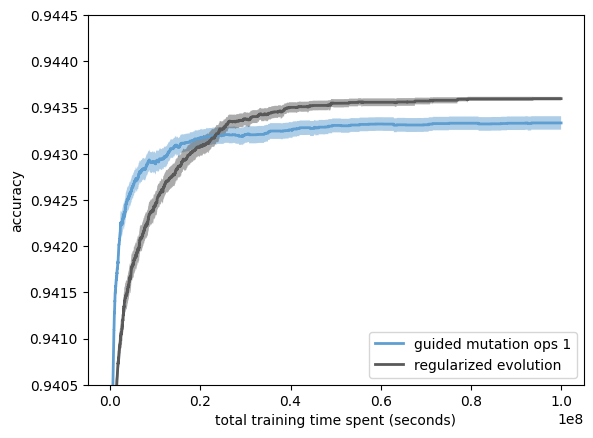

In [4]:
fig, ax = plt.subplots()

means , _ =  plot_all(exp1, ax)


In [ ]:
# save results to folder
! this could overwrite existing files

f1 = os.path.join("..","..","models", "em4", "gm1_1e8.json")
f3 = os.path.join("..","..","models", "em4", "re_1e8.json")

with open(f1, 'w') as file:
    json.dump(exp1["data"]["guided mutation ops 1"][0], file)

with open(f3, 'w') as file:
    json.dump(exp1["data"]["regularized evolution"][0], file)

In [15]:
# plotting means
import numpy as np

steps = len(means[0]) 
print(steps)
thresholds = [0.938,0.939, 0.940, 0.942, 0.9425, 0.943061, 0.9433, means[0][-1]]

gm = []
rr= []
for t in thresholds:
    for i in range(steps):
        if means[0][i] > t:
            gm.append(i)
            break
    for i in range(steps):
        if means[1][i] > t:
            rr.append(i)
            break
print(gm)
print(rr)

print("threshold |  guided mutation  | regularized evolution | speedup of gm over rr ")
for i in range(len(thresholds)):
    if gm[i] <= rr[i]:
        speed_up = "+" + str(int(100-(gm[i]/rr[i]*100))) + "%"
    else: 
        speed_up = str(int(100-(gm[i]/rr[i]*100))) + "%"
    print(f"{thresholds[i]} | {gm[i]}  |  {rr[i]} |  {speed_up} ")

10001
[16, 27, 46, 192, 375, 1403, 4924]
[16, 31, 86, 644, 1041, 1902, 2560, 2611]
threshold |  guided mutation  | regularized evolution | speedup of gm over rr 
0.938 | 16  |  16 |  +0% 
0.939 | 27  |  31 |  +12% 
0.94 | 46  |  86 |  +46% 
0.942 | 192  |  644 |  +70% 
0.9425 | 375  |  1041 |  +63% 
0.943061 | 1403  |  1902 |  +26% 
0.9433 | 4924  |  2560 |  -92% 


IndexError: list index out of range

In [70]:
formatted_thresholds = [f"{t:.4f}" for t in thresholds[:-1]]
formatted_thresholds.append("max")
speedups = []
for i in range(len(thresholds)):
    if gm[i] <= rr[i]:
        speedup = "+" + str(int(100 - (gm[i] / rr[i] * 100))) + "\\%"
    else:
        speedup = str(int(100 - (gm[i] / rr[i] * 100))) + "\\%"
    speedups.append(speedup)
    
print("\\begin{tabular}{|c|" + "c|" * len(formatted_thresholds) + "}")
print("\\hline")
print("accuracy & " + " & ".join(formatted_thresholds) + " \\\\")
print("\\hline")
print("GM & " + " & ".join([str(g) for g in gm]) + " \\\\")
print("\\hline")
print("RE & " + " & ".join([str(r) for r in rr]) + " \\\\")
print("\\hline")
print("speedup & " + " & ".join(speedups) + " \\\\")
print("\\hline")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
accuracy & 0.9380 & 0.9390 & 0.9400 & 0.9420 & 0.9425 & 0.9431 & 0.9433 & max \\
\hline
GM & 16 & 28 & 48 & 215 & 432 & 1910 & 7323 & 9522 \\
\hline
RE & 16 & 31 & 86 & 644 & 1041 & 1902 & 2560 & 2612 \\
\hline
speedup & +0\% & +9\% & +44\% & +66\% & +58\% & 0\% & -186\% & -264\% \\
\hline
\end{tabular}


In [8]:
# save means to folder
! this could overwrite existing files

f1 = os.path.join("..","..","models", "em4", "means_1e8.json")

with open(f1, 'w') as file:
    json.dump(means, file)



In [5]:
# save results to folder
! this could overwrite existing files

f1 = os.path.join("..","..","models", "em4", "gm1_1e8.json")
f3 = os.path.join("..","..","models", "em4", "re_1e8.json")

with open(f1, 'w') as file:
    json.dump(exp1["data"]["guided mutation ops 1"][0], file)

with open(f3, 'w') as file:
    json.dump(exp1["data"]["regularized evolution"][0], file)

In [ ]:
# save results to folder
! this could overwrite existing files

f1 = os.path.join("..","..","models", "em4", "gm1_1e7.json")
f2 = os.path.join("..","..","models", "em4", "gm0_1e7.json")
f3 = os.path.join("..","..","models", "em4", "re_1e7.json")

with open(f1, 'w') as file:
    json.dump(exp1["data"]["guided mutation ops 1"][0], file)

with open(f2, 'w') as file:
    json.dump(exp1["data"]["guided mutation ops 0"][0], file)

with open(f3, 'w') as file:
    json.dump(exp1["data"]["regularized evolution"][0], file)
